In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


sns.set_style("whitegrid")


In [2]:
file_path = "/content/crop_dataset.csv"
df = pd.read_csv(file_path)

df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19689 entries, 0 to 19688
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Crop             19689 non-null  object 
 1   Crop_Year        19689 non-null  int64  
 2   Season           19689 non-null  object 
 3   State            19689 non-null  object 
 4   Area             19689 non-null  float64
 5   Production       19689 non-null  int64  
 6   Annual_Rainfall  19689 non-null  float64
 7   Fertilizer       19689 non-null  float64
 8   Pesticide        19689 non-null  float64
 9   Yield            19689 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 1.5+ MB


,Crop,Crop_Year,Season,State,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
0,Arecanut,1997,Whole Year,Assam,73814.0,56708,2051.4,7024878.38,22882.34,0.796087
1,Arhar/Tur,1997,Kharif,Assam,6637.0,4685,2051.4,631643.29,2057.47,0.710435
2,Castor seed,1997,Kharif,Assam,796.0,22,2051.4,75755.32,246.76,0.238333
3,Coconut,1997,Whole Year,Assam,19656.0,126905000,2051.4,1870661.52,6093.36,5238.051739
4,Cotton(lint),1997,Kharif,Assam,1739.0,794,2051.4,165500.63,539.09,0.420909


In [3]:
print("Missing Values:\n", df.isnull().sum())

duplicates = df.duplicated().sum()
print("\nDuplicate Records:", duplicates)


Missing Values:
 Crop               0
Crop_Year          0
Season             0
State              0
Area               0
Production         0
Annual_Rainfall    0
Fertilizer         0
Pesticide          0
Yield              0
dtype: int64

Duplicate Records: 0


In [4]:
df = df.drop_duplicates()


In [6]:
df.describe()


,Crop_Year,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
count,19689.000000,1.968900e+04,1.968900e+04,19689.000000,1.968900e+04,1.968900e+04,19689.000000
mean,2009.127584,1.799266e+05,1.643594e+07,1437.755177,2.410331e+07,4.884835e+04,79.954009
std,6.498099,7.328287e+05,2.630568e+08,816.909589,9.494600e+07,2.132874e+05,878.306193
min,1997.000000,5.000000e-01,0.000000e+00,301.300000,5.417000e+01,9.000000e-02,0.000000
25%,2004.000000,1.390000e+03,1.393000e+03,940.700000,1.880146e+05,3.567000e+02,0.600000
50%,2010.000000,9.317000e+03,1.380400e+04,1247.600000,1.234957e+06,2.421900e+03,1.030000
75%,2015.000000,7.511200e+04,1.227180e+05,1643.700000,1.000385e+07,2.004170e+04,2.388889
max,2020.000000,5.080810e+07,6.326000e+09,6552.700000,4.835407e+09,1.575051e+07,21105.000000


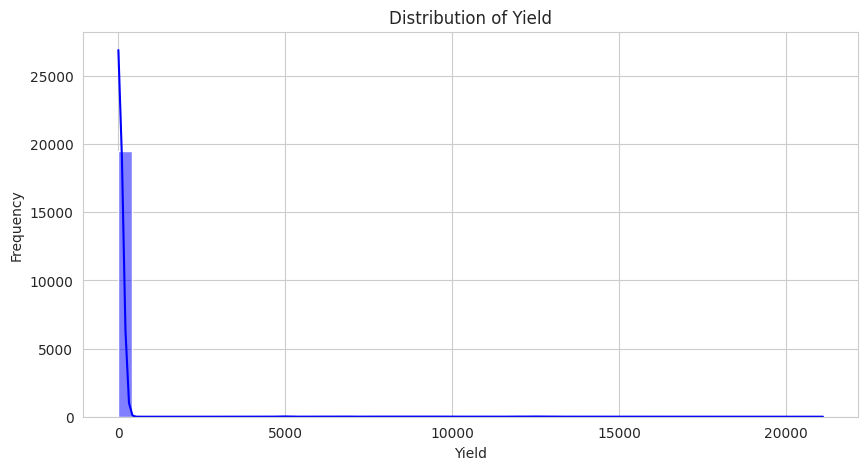

In [7]:
plt.figure(figsize=(10, 5))
sns.histplot(df["Yield"], bins=50, kde=True, color="blue")
plt.title("Distribution of Yield")
plt.xlabel("Yield")
plt.ylabel("Frequency")
plt.show()


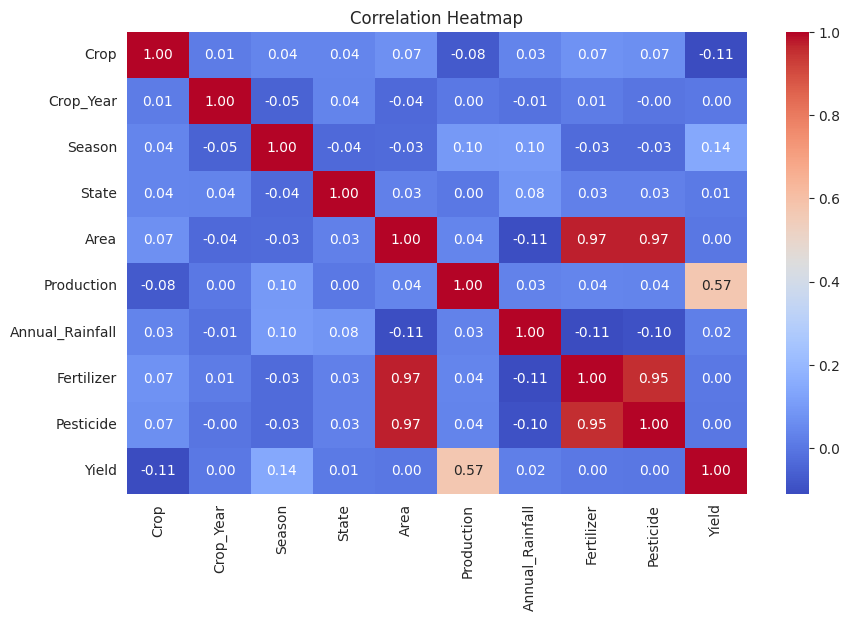

In [9]:
from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()
label_encoders = {}

for col in ["Crop", "State", "Season"]:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col])
    label_encoders[col] = le


plt.figure(figsize=(10, 6))
sns.heatmap(df_encoded.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [11]:
Q1 = df["Yield"].quantile(0.25)
Q3 = df["Yield"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df["Yield"] >= lower_bound) & (df["Yield"] <= upper_bound)]


In [14]:
scaler = StandardScaler()
numerical_cols = ["Area", "Production", "Annual_Rainfall", "Fertilizer", "Pesticide"]
scaled_features = scaler.fit_transform(df[numerical_cols])
scaled_df = pd.DataFrame(scaled_features, columns=numerical_cols)
scaled_df.head()

,Area,Production,Annual_Rainfall,Fertilizer,Pesticide
0,-0.141768,-0.162230,0.792631,-0.179593,-0.118269
1,-0.231980,-0.202194,0.792631,-0.248722,-0.216061
2,-0.239824,-0.205776,0.792631,-0.254733,-0.224564
3,-0.238557,-0.205183,0.792631,-0.253763,-0.223191
4,-0.222647,-0.198823,0.792631,-0.241570,-0.205944


In [17]:
# One-Hot Encoding
# The 'sparse' argument is deprecated in newer versions of scikit-learn.
# Removing it should resolve the issue.
encoder = OneHotEncoder(drop="first", handle_unknown='ignore') # Use handle_unknown='ignore' for categories not seen during fit
categorical_cols = ["Crop", "State", "Season"]
encoded_features = encoder.fit_transform(df[categorical_cols]).toarray() # Convert to dense array if necessary
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols))

In [18]:
df_final = pd.concat([scaled_df, encoded_df, df["Yield"].reset_index(drop=True)], axis=1)

# Display final processed data
df_final.info()
df_final.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15620 entries, 0 to 15619
Data columns (total 94 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Area                        15620 non-null  float64
 1   Production                  15620 non-null  float64
 2   Annual_Rainfall             15620 non-null  float64
 3   Fertilizer                  15620 non-null  float64
 4   Pesticide                   15620 non-null  float64
 5   Crop_Arhar/Tur              15620 non-null  float64
 6   Crop_Bajra                  15620 non-null  float64
 7   Crop_Banana                 15620 non-null  float64
 8   Crop_Barley                 15620 non-null  float64
 9   Crop_Black pepper           15620 non-null  float64
 10  Crop_Cardamom               15620 non-null  float64
 11  Crop_Cashewnut              15620 non-null  float64
 12  Crop_Castor seed            15620 non-null  float64
 13  Crop_Coconut                156

,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Crop_Arhar/Tur,Crop_Bajra,Crop_Banana,Crop_Barley,Crop_Black pepper,...,State_Tripura,State_Uttar Pradesh,State_Uttarakhand,State_West Bengal,Season_Kharif,Season_Rabi,Season_Summer,Season_Whole Year,Season_Winter,Yield
0,-0.141768,-0.162230,0.792631,-0.179593,-0.118269,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.796087
1,-0.231980,-0.202194,0.792631,-0.248722,-0.216061,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.710435
2,-0.239824,-0.205776,0.792631,-0.254733,-0.224564,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.238333
3,-0.238557,-0.205183,0.792631,-0.253763,-0.223191,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.420909
4,-0.222647,-0.198823,0.792631,-0.241570,-0.205944,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.643636


In [19]:
X = df_final.drop(columns=["Yield"])
y = df_final["Yield"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
!pip install xgboost lightgbm catboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 53.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


In [22]:
!pip install --force-reinstall catboost

  Using cached catboost-1.2.7-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.2 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.9/101.9 kB 6.9 MB/s eta 0:00:00
Using cached catboost-1.2.7-cp311-cp311-manylinux2014_x86_64.whl (98.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 15.3 MB/s eta 0:00:00
   ━━━━

In [30]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
}
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)


    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MAE": mae, "RMSE": rmse, "R² Score": r2}


results_df = pd.DataFrame(results).T.sort_values(by="R² Score", ascending=False)
print("\nModel Performance Comparison:")
print(results_df)


best_model_name = results_df.index[0]
print(f" Best Performing Model: {best_model_name}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1438
[LightGBM] [Info] Number of data points in the train set: 12496, number of used features: 87
[LightGBM] [Info] Start training from score 1.009536

Model Performance Comparison:
                        MAE      RMSE  R² Score
LightGBM           0.108694  0.179842  0.929211
XGBoost            0.113957  0.189286  0.921581
Random Forest      0.107751  0.194658  0.917066
Gradient Boosting  0.180852  0.268884  0.841761
Decision Tree      0.145800  0.270601  0.839733
Ridge Regression   0.329295  0.470328  0.515845
Linear Regression  0.329153  0.470738  0.514999
Lasso Regression   0.518305  0.660544  0.045036

🏆 Best Performing Model: LightGBM


In [32]:
!pip install --upgrade scikit-learn threadpoolctl

In [34]:
!pip install --upgrade numpy
!pip install --upgrade scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 79.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
catboost 1.2.7 requires numpy<2.0,>=1.16.0, but you have numpy 2.2.4 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.


In [35]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
import threadpoolctl  # Although the error isn't directly related to threadpoolctl, it's good to keep it for potential thread management

best_model_name = results_df.index[0]
best_model = models[best_model_name]

param_grid = {
    "n_estimators": [100, 200, 500],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [3, 5, 7, 10]
}

# Reducing n_jobs or setting it to 1 can prevent parallelization issues.
# Try with a lower number of jobs first, like n_jobs=2
# if it still fails, use n_jobs=1 to disable parallelism.
grid_search = RandomizedSearchCV(best_model, param_grid, cv=3, scoring="r2", n_jobs=2, verbose=1, n_iter=10)
grid_search.fit(X_train, y_train)

print("Best Parameters for", best_model_name, ":", grid_search.best_params_)
print("  Best R² Score from Grid Search:", grid_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1438
[LightGBM] [Info] Number of data points in the train set: 12496, number of used features: 87
[LightGBM] [Info] Start training from score 1.009536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1438
[LightGBM] [Info] Number of data points in the train set: 12496, number of used features: 87
[LightGBM] [Info] Start training from score 1.009536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

<ipython-input-37-356e67fbbe1c>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance_df[:20], palette="viridis")


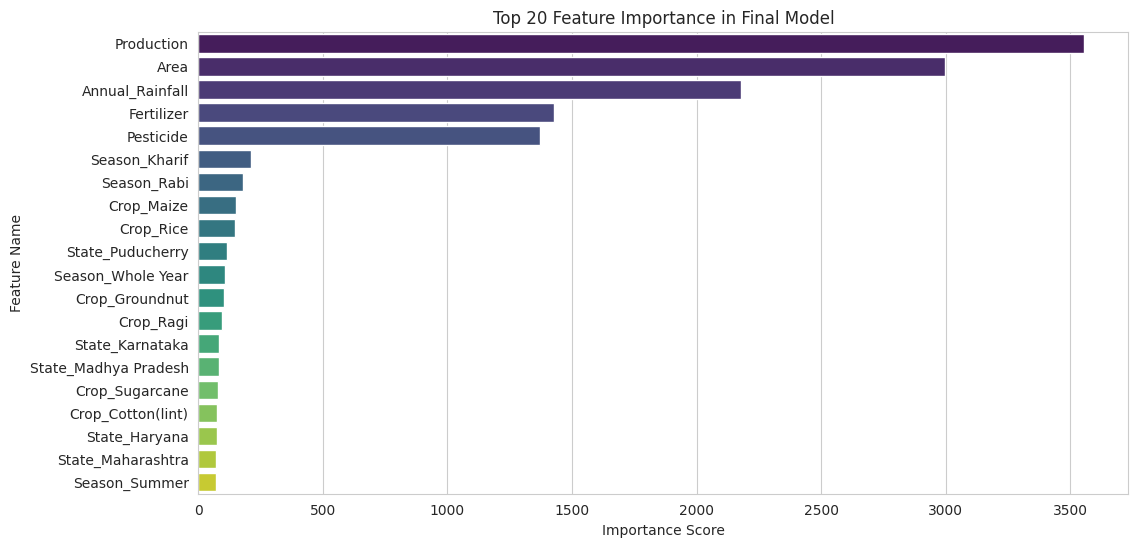

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns


final_model = best_model.set_params(**grid_search.best_params_)
final_model.fit(X_train, y_train)


importances = final_model.feature_importances_
feature_names = X_train.columns


feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)


plt.figure(figsize=(12, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df[:20], palette="viridis")
plt.title("Top 20 Feature Importance in Final Model")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.show()


In [38]:
import joblib

joblib.dump(final_model, "best_crop_yield_model.pkl")




['best_crop_yield_model.pkl']

In [40]:
new_data = np.array([[1200, 500, 800, 300, 5, "2019", "Kharif", "Maharashtra"]])

new_data_df = pd.DataFrame(new_data, columns=["Area", "Production", "Annual_Rainfall", "Fertilizer", "Pesticide", "Crop", "State", "Season"])

numerical_cols = ["Area", "Production", "Annual_Rainfall", "Fertilizer", "Pesticide"]
new_data_df[numerical_cols] = scaler.transform(new_data_df[numerical_cols])

categorical_cols = ["Crop", "State", "Season"]
new_data_encoded = encoder.transform(new_data_df[categorical_cols]).toarray()

new_data_encoded_df = pd.DataFrame(new_data_encoded, columns=encoder.get_feature_names_out(categorical_cols))

new_data_final = pd.concat([new_data_df[numerical_cols].reset_index(drop=True), new_data_encoded_df], axis=1)


predicted_yield = final_model.predict(new_data_final)
print("Predicted Crop Yield:", predicted_yield[0])

Predicted Crop Yield: 1.0155436203518868


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [41]:
pip install flask joblib


In [43]:
from sklearn.preprocessing import LabelEncoder
import joblib

# Encode categorical features
season_encoder = LabelEncoder()
df["Season"] = season_encoder.fit_transform(df["Season"])

state_encoder = LabelEncoder()
df["State"] = state_encoder.fit_transform(df["State"])

# Save encoders for later use
joblib.dump(season_encoder, "season_encoder.pkl")
joblib.dump(state_encoder, "state_encoder.pkl")


['state_encoder.pkl']

In [44]:
import joblib

# Load the saved encoders
season_encoder = joblib.load("season_encoder.pkl")
state_encoder = joblib.load("state_encoder.pkl")

# Print the classes to verify they are correct
print("✅ Season Encoder Classes:", season_encoder.classes_)
print("✅ State Encoder Classes:", state_encoder.classes_)


✅ Season Encoder Classes: [0 1 2 3 4 5]
✅ State Encoder Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]


In [45]:
season_encoder = LabelEncoder()
df["Season"] = season_encoder.fit_transform(df["Season"])
state_encoder = LabelEncoder()
df["State"] = state_encoder.fit_transform(df["State"])

joblib.dump(season_encoder, "season_encoder.pkl")
joblib.dump(state_encoder, "state_encoder.pkl")

print("✅ Encoders saved successfully!")


✅ Encoders saved successfully!
